# Semana 1

In [1]:
#!pip install googletrans==4.0.0-rc1

In [2]:
import pandas as pd
import numpy as np
from googletrans import Translator

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/sthemonica/alura-voz/main/Dados/Telco-Customer-Churn.json')
display(df.head(2))

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [4]:
%%time
# Separando valores que estão em formato dict, e retornando para o dataframe
customer = pd.json_normalize(df.customer)
phone = pd.json_normalize(df.phone)
internet = pd.json_normalize(df.internet)
account = pd.json_normalize(df.account)
df_base = pd.concat([df.customerID, df.Churn, customer, phone, internet, account], axis = 1)


# Traduzindo nomes das colunas manualmente
df_base.columns = ['clienteID', 
                   'Churn', 
                   'genero_cliente', 
                   'mais_que_65_anos', 
                   'possui_parceiro_a', 
                  'possui_dependentes', 
                  'meses_contrato',
                  'servico_telefonico',
                  'multiplas_linhas',
                  'servico_internet',
                  'assinatura_seguranca',
                  'assinatura_backup',
                  'assinatura_protecao_dispositivo',
                  'assinatura_suporte',
                  'assinatura_TV',
                  'assinatura_streaming',
                  'contrato',
                  'fatura_digital',
                  'forma_pagamento',
                  'total_servicos_mes',
                  'total_gasto']

# Traduzindo valores de dentro da tabela
# df_base.replace(['Yes', 'No', 'Female', 'Male'], [1, 0, 1, 0], inplace=True)

# Excluindo linhas com dados vazios na coluna Churn
df_base.drop(df_base[df_base.Churn == ''].index, inplace = True)
df_base.reset_index()

# Substituindo valores vazios por 0 na coluna total_gasto
df_base.total_gasto .replace(' ', 0, inplace = True)

# Convertendo coluna total_gasto para float
df_base.total_gasto = df_base.total_gasto.apply(pd.to_numeric)

# Criando coluna gastos_diarios, quando meses_contrato < 0, usar coluna total_servicos_mes,
# quando meses_contrato > 0 considera total_gasto
df_base['gastos_diarios'] = [df_base.total_gasto[i] / (df_base.meses_contrato[i] * 30) 
                             if df_base.meses_contrato[i] > 0 
                             else df_base.total_servicos_mes[i] / 30 
                             for i in df_base.index]

df_base.head(2)

Wall time: 1.05 s


,clienteID,Churn,genero_cliente,mais_que_65_anos,possui_parceiro_a,possui_dependentes,meses_contrato,servico_telefonico,multiplas_linhas,servico_internet,...,assinatura_protecao_dispositivo,assinatura_suporte,assinatura_TV,assinatura_streaming,contrato,fatura_digital,forma_pagamento,total_servicos_mes,total_gasto,gastos_diarios
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3,2.197407
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4,2.008889


# Semana 2

### Validação de algumas colunas

In [5]:
df_base.columns

Index(['clienteID', 'Churn', 'genero_cliente', 'mais_que_65_anos',
       'possui_parceiro_a', 'possui_dependentes', 'meses_contrato',
       'servico_telefonico', 'multiplas_linhas', 'servico_internet',
       'assinatura_seguranca', 'assinatura_backup',
       'assinatura_protecao_dispositivo', 'assinatura_suporte',
       'assinatura_TV', 'assinatura_streaming', 'contrato', 'fatura_digital',
       'forma_pagamento', 'total_servicos_mes', 'total_gasto',
       'gastos_diarios'],
      dtype='object')

In [6]:
df_base.assinatura_protecao_dispositivo.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [7]:
df_base[df_base.multiplas_linhas == 'No phone service'].shape[0]

682

In [8]:
pd.crosstab(df_base.Churn, df_base.servico_internet)

servico_internet,DSL,Fiber optic,No
Churn,,,
No,1962,1799,1413
Yes,459,1297,113


In [9]:
df_base.groupby('servico_internet').count()

,clienteID,Churn,genero_cliente,mais_que_65_anos,possui_parceiro_a,possui_dependentes,meses_contrato,servico_telefonico,multiplas_linhas,assinatura_seguranca,...,assinatura_protecao_dispositivo,assinatura_suporte,assinatura_TV,assinatura_streaming,contrato,fatura_digital,forma_pagamento,total_servicos_mes,total_gasto,gastos_diarios
servico_internet,,,,,,,,,,,,,,,,,,,,,
DSL,2421,2421,2421,2421,2421,2421,2421,2421,2421,2421,...,2421,2421,2421,2421,2421,2421,2421,2421,2421,2421
Fiber optic,3096,3096,3096,3096,3096,3096,3096,3096,3096,3096,...,3096,3096,3096,3096,3096,3096,3096,3096,3096,3096
No,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,...,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526


In [10]:
df_base.groupby('assinatura_seguranca').count()

,clienteID,Churn,genero_cliente,mais_que_65_anos,possui_parceiro_a,possui_dependentes,meses_contrato,servico_telefonico,multiplas_linhas,servico_internet,...,assinatura_protecao_dispositivo,assinatura_suporte,assinatura_TV,assinatura_streaming,contrato,fatura_digital,forma_pagamento,total_servicos_mes,total_gasto,gastos_diarios
assinatura_seguranca,,,,,,,,,,,,,,,,,,,,,
No,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,...,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498
No internet service,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,...,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526
Yes,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019


In [11]:
df_base.groupby('assinatura_backup').count()

,clienteID,Churn,genero_cliente,mais_que_65_anos,possui_parceiro_a,possui_dependentes,meses_contrato,servico_telefonico,multiplas_linhas,servico_internet,...,assinatura_protecao_dispositivo,assinatura_suporte,assinatura_TV,assinatura_streaming,contrato,fatura_digital,forma_pagamento,total_servicos_mes,total_gasto,gastos_diarios
assinatura_backup,,,,,,,,,,,,,,,,,,,,,
No,3088,3088,3088,3088,3088,3088,3088,3088,3088,3088,...,3088,3088,3088,3088,3088,3088,3088,3088,3088,3088
No internet service,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,...,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526
Yes,2429,2429,2429,2429,2429,2429,2429,2429,2429,2429,...,2429,2429,2429,2429,2429,2429,2429,2429,2429,2429


In [12]:
df_base.groupby('assinatura_protecao_dispositivo').count()

,clienteID,Churn,genero_cliente,mais_que_65_anos,possui_parceiro_a,possui_dependentes,meses_contrato,servico_telefonico,multiplas_linhas,servico_internet,...,assinatura_backup,assinatura_suporte,assinatura_TV,assinatura_streaming,contrato,fatura_digital,forma_pagamento,total_servicos_mes,total_gasto,gastos_diarios
assinatura_protecao_dispositivo,,,,,,,,,,,,,,,,,,,,,
No,3095,3095,3095,3095,3095,3095,3095,3095,3095,3095,...,3095,3095,3095,3095,3095,3095,3095,3095,3095,3095
No internet service,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,...,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526
Yes,2422,2422,2422,2422,2422,2422,2422,2422,2422,2422,...,2422,2422,2422,2422,2422,2422,2422,2422,2422,2422


### Análise da variável target - Churn

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df_base.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

#### Avaliando por gênero

In [15]:
df_genero = pd.crosstab(df_base.Churn, df_base.genero_cliente)
df_genero

genero_cliente,Female,Male
Churn,,
No,2549,2625
Yes,939,930


In [16]:
df_base.groupby('genero_cliente')['Churn'].count()

genero_cliente
Female    3488
Male      3555
Name: Churn, dtype: int64

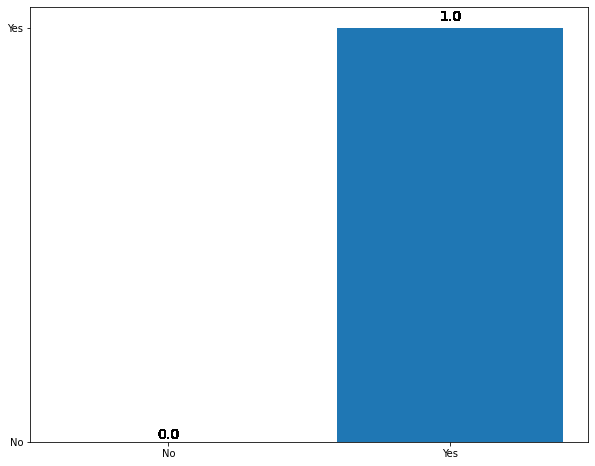

In [17]:
df_genero = pd.crosstab(df_base.Churn, df_base.genero_cliente)

fig, ax = plt.subplots(figsize=(10, 8))

grafico = ax.bar(x = 'Churn', height=df_base.Churn, data = df_base)

for barra in grafico:
  # Pegando a altura(valor) e largura de cada barra
    altura = barra.get_height()
    largura = barra.get_width()

    '''
      Posição x(xpos) e y(ypos) de cada barra. Aqui temos três casos de y pos:
      1º - colocando o rótulo acima da barra
      2º - colocando o rótulo no meio da barra
      3º - colocando o rótulo na base da barra
      Para selecionar o desejado, é só descomentar o ypos que quer fazer uso.
    '''
    xpos = barra.get_x() + largura/2
    ypos = 1.01 * altura
    # ypos = barra.get_y() + altura/2
    # ypos = barra.get_y()

    # Adicionando o rótulo nas barras (x= coordenada x, y = coordenada y, s = texto desejado)
    ax.text(x = xpos, y = ypos, s = altura, ha='center', va='bottom', fontsize=14)

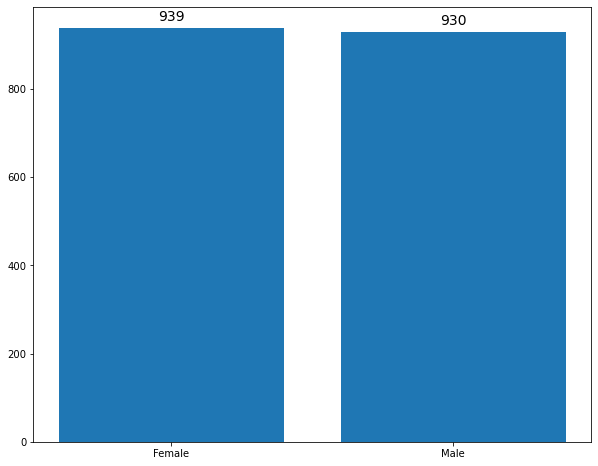

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

# grafico = df_genero.plot(kind = 'bar')
grafico = ax.bar(x = df_genero.columns, height=df_genero.loc['Yes'], data = df_genero)

for barra in grafico:
  # Pegando a altura(valor) e largura de cada barra
    altura = barra.get_height()
    largura = barra.get_width()

    '''
      Posição x(xpos) e y(ypos) de cada barra. Aqui temos três casos de y pos:
      1º - colocando o rótulo acima da barra
      2º - colocando o rótulo no meio da barra
      3º - colocando o rótulo na base da barra
      Para selecionar o desejado, é só descomentar o ypos que quer fazer uso.
    '''
    xpos = barra.get_x() + largura/2
    ypos = 1.01 * altura
    # ypos = barra.get_y() + altura/2
    # ypos = barra.get_y()

    # Adicionando o rótulo nas barras (x= coordenada x, y = coordenada y, s = texto desejado)
    ax.text(x = xpos, y = ypos, s = altura, ha='center', va='bottom', fontsize=14)

#### Se acima de 65 anos

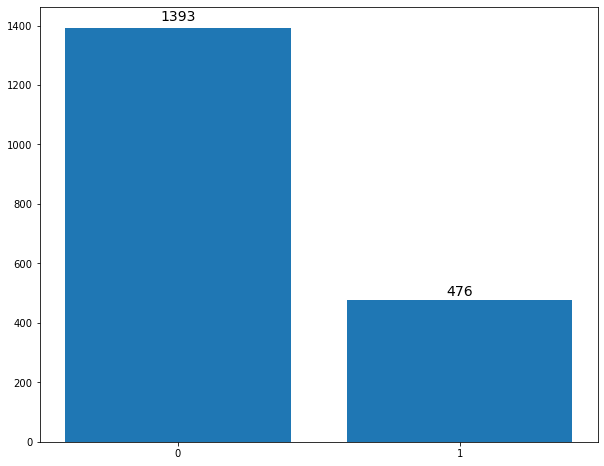

In [19]:
df_analise = pd.crosstab(df_base.Churn, df_base.mais_que_65_anos.astype(str))

fig, ax = plt.subplots(figsize=(10, 8))

grafico = ax.bar(x = df_analise.columns, height=df_analise.loc['Yes'], data = df_analise.loc['Yes'])

for barra in grafico:
  # Pegando a altura(valor) e largura de cada barra
    altura = barra.get_height()
    largura = barra.get_width()

    '''
      Posição x(xpos) e y(ypos) de cada barra. Aqui temos três casos de y pos:
      1º - colocando o rótulo acima da barra
      2º - colocando o rótulo no meio da barra
      3º - colocando o rótulo na base da barra
      Para selecionar o desejado, é só descomentar o ypos que quer fazer uso.
    '''
    xpos = barra.get_x() + largura/2
    ypos = 1.01 * altura
    # ypos = barra.get_y() + altura/2
    # ypos = barra.get_y()

    # Adicionando o rótulo nas barras (x= coordenada x, y = coordenada y, s = texto desejado)
    ax.text(x = xpos, y = ypos, s = altura, ha='center', va='bottom', fontsize=14)